# Tweet Sentiment Analysis using Sentiment140 dataset

In this notebook, we built a tweet sentiment analysis. We used the **Sentiment140 dataset with 1.6 million tweets** dataset which you can download it on Kaggle from [here](https://www.kaggle.com/datasets/kazanova/sentiment140/code?resource=download).

## Import libraries
First, we start by importing the libraries. 

In [8]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import time
import os
import kaggle

import re
import string
import contractions
from autocorrect import Speller
import nltk

import sklearn 

## Download the dataset
We download the dataset from the following [link](https://www.kaggle.com/datasets/kazanova/sentiment140/code?resource=download) if it is not already downloaded.

In [9]:
DATASET_PATH = './data/dataset.csv'

if not os.path.exists(DATASET_PATH):
    print("Downloading Dataset from Kaggle...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('kazanova/sentiment140/download', path='./data/', unzip=True)
    os.rename('./data/training.1600000.processed.noemoticon.csv', './data/dataset.csv')

## Dataset exploration

### Load dataset

Let's read the data from the CSV file. We use the `pandas` library to read the CSV file.

In [10]:
dataset = pd.read_csv(DATASET_PATH,header=None, encoding='latin-1')
dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


As we can see on the first 4 lines of the dataset, we have 6 columns. In order, they are:

1. sentiment (0 for negative and 4 for positive)
2. id (unique number)
3. date of the tweet
4. query 
5. tweet author username
6. text content of the tweet

We will use the 1st column (the sentiment) as the label for our model, and the 6th column (the text content of the tweet) as the input. The other columns are not useful for our model. We can drop them.

In [11]:
dataset.columns = ['sentiment', 'id', 'date', 'query', 'user_name', 'tweet'] # rename columns
dataset = dataset.drop(['id', 'date', 'query', 'user_name'], axis=1) # drop unnecessary columns
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Explore dataset

Let's explore the dataset. We will check the number of tweets for each sentiment.

To do so, we will group the dataset by the sentiment, and count the number of tweets for each sentiment. We can see that 0 is negative and 4 is positive.

In [12]:
label_to_sentiment = {0:"Negative", 4:"Positive"}

dataset['sentiment'] = dataset['sentiment'].replace(label_to_sentiment) # replace labels with actual sentiment
distribution = dataset['sentiment'].value_counts()

We can now display the number of tweets for each sentiment. As we can see the dataset is well balanced. We have 800,000 tweets for each sentiment. That's perfect.

Text(0.5, 1.0, 'Sentiment distribution')

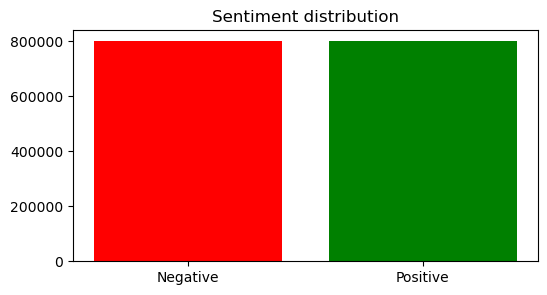

In [13]:
plt.figure(figsize=(6, 3))
plt.bar(distribution.index, distribution.values, color=['red', 'green'])
plt.title('Sentiment distribution')

## Data preprocessing

We will now clean the data. We based ourselves on this [tutorial](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) using `NLTK` library. 

### Text cleaning

First of all, we clean the text by lowercasing, removing the links, extra whitespace and punctuations. We also replace common contractions by full words.

At the beginning, we tried to correct the spelling of the words. However, it takes a lot of time to process the data. So we decided to remove this step. And the model still works well.

In [14]:
from nltk.tokenize import regexp

def text_preprocessing(text):
     # lowercase
    text = text.lower()
    # remove extra whitespaces
    text = " ".join(text.split())
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove identifiers (e.g. @user)
    text = re.sub(r'@\S+', '', text)
    # replace common contractions by full words
    text = contractions.fix(text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove small words
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # spell correction (takes too much time, and doesn't improve that much accuracy)
    # text = Speller(lang='en', fast=True)(text)
    
    return text

Apply the cleaning function to the dataset. Tweet are much cleaner now.

In [15]:
dataset['tweet'] = dataset['tweet'].apply(text_preprocessing)
dataset.head()

,sentiment,tweet
0,Negative,awww that bummer you shoulda got david ca...
1,Negative,upset that cannot update his facebook texti...
2,Negative,dived many times for the ball managed save ...
3,Negative,whole body feels itchy and like its fire
4,Negative,not behaving all mad why here because...


### Tokenization
Here we will do several steps to tokenize the text. We will:

1. **Tokenize** the text using the `word_tokenize` function from `NLTK` library. This will split the text into words called tokens. 
2. Remove the **stopwords** using the `stopwords` function from `NLTK` library. Stopwords are trivial words like “I”, “the”, “you”, etc. that appear so frequently in the text that they may distort many NLP operations without adding much valuable information.
3. Remove words with **low frequency** and very **high frequency**. We are going to filter out words that do not appear enough in our dataset and those who appear too much. For that, we are going to set the low and high threshold. All words outside of this threshold will be filtered out.
4. **Stem** the words using the `PorterStemmer` function from `NLTK` library. Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. For example, the words “fishing”, “fished”, and “fisher” all have the stem “fish”.

We used stemming instead of lemmatization because in our case, we want to keep the words as short as possible. Lemmatization is a more complex process that takes into account the context of the word. We often use lemmatization when it comes to chatbots or question answering systems, where the context is important.

#### Setup for tokenization, stopwords and stemming

In [16]:
# word tokenizing
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/constant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# get stopwords (words that don't add much meaning to a sentence)
nltk.download('stopwords') 
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/constant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# get word frequency in the dataset
word_occurrences = {} # dictionary to store word occurrences
for tweet in dataset['tweet']:
    words = tweet.split()
    for word in words:
        if word in word_occurrences:
            word_occurrences[word] += 1
        else:
            word_occurrences[word] = 1
            
MIN_WORD_OCCURRENCE = 20 # same as in the chatbot course
TOP_FREQ_WORDS = 10 # defined by exploring the dataset
most_common_words = sorted(word_occurrences, key=word_occurrences.get, reverse=True)[:TOP_FREQ_WORDS]

In [19]:
# get stem of words (e.g. 'running' -> 'run')
nltk.download('wordnet')
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/constant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Tokenization, stopwords and stemming

In [20]:
# get number of words inside the dataset before tokenizing
all_words_before_tokenization = {}
for tweet in dataset['tweet']:
    for word in tweet.split():
        if word in all_words_before_tokenization:
            all_words_before_tokenization[word] += 1
        else:
            all_words_before_tokenization[word] = 1
number_words_before_tokenization = len(all_words_before_tokenization)

In [21]:
def tokenize(text):
    # 1. tokenize
    raw_tokens = nltk.word_tokenize(text)
    parsed_tokens = []
    
    for token in raw_tokens:
        # 2. remove stopwords
        if token not in stopwords:
            # 3. remove words with low frequency and very high frequency
            if token in word_occurrences and word_occurrences[token] > MIN_WORD_OCCURRENCE and word_occurrences[token] not in most_common_words:
                # # 4. stemming
                parsed_tokens.append(stemmer.stem(token))
                
    
    return parsed_tokens

Apply the tokenization function to the dataset.

In [22]:
dataset['tweet'] = dataset['tweet'].apply(tokenize)
dataset.head()

,sentiment,tweet
0,Negative,"[awww, bummer, shoulda, got, david, carr, thir..."
1,Negative,"[upset, updat, facebook, text, might, cri, res..."
2,Negative,"[mani, time, ball, manag, save, rest]"
3,Negative,"[whole, bodi, feel, itchi, like, fire]"
4,Negative,"[behav, mad, see]"


In [23]:
# get number of words inside the dataset after tokenizing
all_words_after_tokenization = {}
for tweet in dataset['tweet']:
    for word in tweet:
        if word in all_words_after_tokenization:
            all_words_after_tokenization[word] += 1
        else: 
            all_words_after_tokenization[word] = 1
number_words_after_tokenization = len(all_words_after_tokenization)

### Compare number of words before and after tokenization

As we can see, we went from 416 891 words to only 15 045. This is a huge reduction in the number of words. This will help us to train our model faster.

In [24]:
print("Number of words in the dataset before tokenization: ", number_words_before_tokenization)
print("Number of words in the dataset after tokenization: ", number_words_after_tokenization)

Number of words in the dataset before tokenization:  416891
Number of words in the dataset after tokenization:  15045


### Data visualization
Let's visualize the data. We will use the `wordcloud` library to display the most frequent words from positive and negative tweets. We can already see some interesting words like "love", "good", "great", "bad", "hate", etc.

In [25]:
def visualize_wordcloud(sentiment):
    words = []
    for tweet in dataset[dataset['sentiment'] == sentiment]['tweet']:
        words += tweet
    
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=500, random_state=21, max_font_size=110).generate(" ".join(words))
    plt.figure(figsize=(8, 4))
    plt.title(f"Most common words in {sentiment} tweets")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

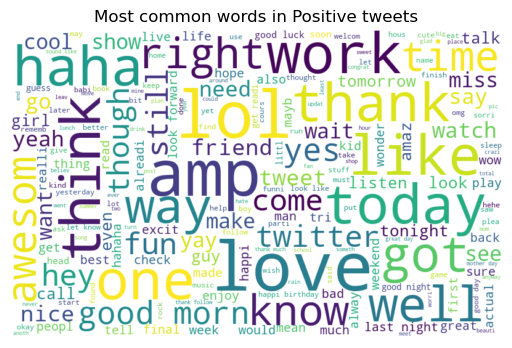

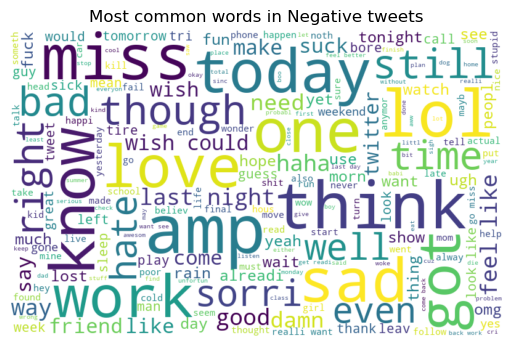

In [26]:
visualize_wordcloud(label_to_sentiment[4]) # positive tweets
visualize_wordcloud(label_to_sentiment[0]) # negative tweets

## Model building
### Split dataset (train/test)
We split the dataset into a training set and a test set. We will use the training set to train our model and the test set to evaluate the performance of our model. 
We will use the `train_test_split` function from `sklearn` library. This function will automatically split the dataset into 2 sets. We will use 80% of the dataset for the training set and 20% for the test set. `train_test_split` also shuffles the dataset before splitting it.

In [40]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE
MAX_SEQUENCE_LENGTH = 30

In [41]:
train_test_split = sklearn.model_selection.train_test_split
train_data, test_data = train_test_split(dataset, test_size=TEST_SIZE, random_state=42)

In [42]:
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

Training data size: 1280000
Testing data size: 320000


### Tokenization
We should now tokenize the dataset. This means that we should convert the text into numbers.
We will use the `Tokenizer` function from `keras` library. This function will convert the text into a sequence of integers. Each integer will represent a word in the dataset.

In [43]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])

vocab = tokenizer.word_index
vocab_size = len(vocab) + 1

In [44]:
print(f"Number of unique words: {vocab_size}")

Number of unique words: 15046


Now we have a dictionary that maps each word to an integer. We can use this dictionary to convert the text into a sequence of integers.

### Padding
All tweets have different lengths. We will use the `pad_sequences` function from `keras` library. This function will add zeros to the sequences to make them all the same length. That's why we defined the `MAX_LENGTH_SEQUENCE` variable at the beginning of this section.

In [45]:
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['tweet']), padding='post', maxlen= MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['tweet']), padding='post', maxlen= MAX_SEQUENCE_LENGTH)

Let's check the shape of the padded sequences.

In [46]:
print(f"Shape of training data: {x_train.shape}")
print(f"Shape of testing data: {x_test.shape}")

Shape of training data: (1280000, 30)
Shape of testing data: (320000, 30)


In [47]:
x_train[:2]

array([[ 853,   27,    7, 1769, 1684, 1871,   84,  131,    3,  573,  119,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 691, 2636,  415,  202,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

### Label encoding
Our model will predict two classes: positive or negative. We need to convert the labels into numbers. We will use the `LabelEncoder` function from `sklearn` library. This function will convert the labels into numbers.

In [48]:
labels = train_data['sentiment'].unique().tolist()

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(train_data['sentiment']) 
# encode labels
y_train = label_encoder.transform(train_data.sentiment.to_list())
y_test = label_encoder.transform(test_data.sentiment.to_list())
# reshape to 2D arrays
y_train= y_train.reshape(-1,1) 
y_test = y_test.reshape(-1,1)

In [49]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (1280000, 1)
Shape of y_test: (320000, 1)


### Embedding Matrix using a pre-trained model glove
As we've seen in class, we can use word embedding to represent words as vectors. It's a way to represent words in a dense vector space where words that have similar meanings will be closer to each other in the space.

Like in course, we will use the `GloVe` pre-trained model. This model is trained on a Wikipedia 2014 + Gigaword 5 dataset. It contains 400,000 unique words and 50 dimensions. We will use this model to create the embedding matrix.

#### Download GloVe model if not already done

In [ ]:
GLOVE_6B_PATH = './data/glove.6B.300d.txt'

if not os.path.exists(GLOVE_6B_PATH):
    if not os.path.exists('./data/glove.6B.zip'):
        print("Downloading GloVe...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip -O ./data/glove.6B.zip
    print("Extracting GloVe...")
    !unzip ./data/glove.6B.zip -d ./data/
    os.remove('./data/glove.6B.zip')
    os.remove('./data/glove.6B.50d.txt')
    os.remove('./data/glove.6B.100d.txt')
    os.remove('./data/glove.6B.200d.txt')

#### Create a dictionary of words and their GloVe vector representation

In [ ]:
word2vec_index = {}

f = open(GLOVE_6B_PATH)

for line in f:
    values = line.split()
    word = value = values[0]
    index = np.asarray(values[1:], dtype="float32")
    word2vec_index[word] = index
    
f.close()
print("The number of word vectors are: ", len(word2vec_index))

### Create embedding matrix
We will now create the embedding matrix. This matrix will contain the GloVe vector representation of each word in our dataset. We will use the `create_embedding_matrix` function that we defined at the beginning of this section.

In [ ]:
EMBEDDING_DIM = 300 # dimension of the word vectors
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
EPOCHS = 64
MODEL_PATH = './output/best_model.h5'

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in vocab.items():
    embedding_vector = word2vec_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

### Build the model architecture
We use a sequence to sequence model with LSTM layers. As we've seen in the word cloud preisualisation, some words where both positive and negative. We will use a bidirectional LSTM layer to take into account the context of the words. We will also use a dropout layer to avoid overfitting.

[![model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)]


The model architecture is the following:

1. **Embedding layer:** this layer will convert the sequences of integers into sequences of vectors. The vectors will be the GloVe vector representation of the words. The embedding layer will use the embedding matrix that we created earlier.
   
2. **Conv1D layer:** this layer will extract features from the sequences of vectors.

3. **LSTM layer:** memory unit that will learn the context of the words.

4. **Dense:** fully connected layer that will output the probability of the tweet being positive or negative.

In [ ]:
sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # input layer
embedding_sequences = embedding_layer(sequence_input) # embedding layer

# 1D convolution's Neural Network
x = tf.keras.layers.SpatialDropout1D(0.2)(embedding_sequences) # Dropout for embedding layer to prevent overfitting
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x) # 64 filters, 5 kernel size
# Bidirectional LSTM
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(512, activation='relu')(x) # Fully connected layer
x = tf.keras.layers.Dropout(0.5)(x) # Dropout to prevent overfitting
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Fully connected layer

# Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # 1 neuron for binary classification

# Create model
model = tf.keras.Model(sequence_input, outputs)

## Model training
We can build our model. It uses `Adam` optimizer and `binary_crossentropy` loss function since it's a binary classification problem. We use the `accuracy` metric to evaluate the model.

We've also defined 2 callbacks to save the best model and to change the learning rate if the model is not improving.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, min_lr=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[reduceLROnPlateau, checkpoint])

## Model Evaluation
We can evaluate the model on the testing dataset. 

### Learning curves
We can plot the learning curves to see how the model is improving during the training.

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

### Prediction on test dataset

In [ ]:
y_pred = model.predict(x_test, verbose=1, batch_size=BATCH_SIZE)
y_pred = y_pred = (y_pred > 0.5) 

#### Accuracy, precision, recall and F1 score
We can use the `classification_report` function from `sklearn` library to get the accuracy, precision, recall and F1 score.

In [ ]:
classification_report = sklearn.metrics.classification_report(y_test, y_pred, target_names=labels)

#### Confusion matrix

We can also plot the confusion matrix to see the performance of the model on the testing dataset.

In [ ]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel = 'Predicted'
plt.ylabel = 'Actual'
plt.title = 'Confusion Matrix'
plt.show()

## Predict on new data
We can now use the model to predict the sentiment of new tweets.

In [ ]:
# load the model if necessary
model = tf.keras.models.load_model('./model.h5')

In [ ]:
def predict_sentiment(tweet):
    tweet = text_preprocessing(tweet)
    tweet_tokens = tokenize(tweet)
    tweet_sequence = pad_sequences(tokenizer.texts_to_sequences([tweet]), padding='post', maxlen=MAX_SEQUENCE_LENGTH)
    
    sentiment = model.predict(tweet)
    if sentiment < 0.5:
        print("Negative Sentiment")
    else:
        print("Positive Sentiment")